# Prep chip order

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders
dig66


### Load selected designs

In [2]:
input_json = os.path.join(os.getcwd(), "04_run_af2_short", "to_order.json")
to_order_df = pd.read_json(input_json)

In [3]:
subpools = {}
i = 0
for length in set(to_order_df.chA_length.values):
    subset = to_order_df[to_order_df["chA_length"] == length]
    if len(subset) < 1000:
        subpools[i] = subset
        i += 1
    else:
        for split in np.array_split(subset, int(len(subset) / 1000) + 1):
            subpools[i] = split
            i += 1

In [4]:
for key, value in subpools.items():
    print(key, len(value))

0 494
1 907
2 907
3 907
4 907
5 907
6 907
7 907
8 907
9 907
10 782
11 781
12 781
13 946
14 946
15 945
16 945
17 945
18 945
19 945


### Make functions to domesticate sequences uses Ryan's `domesticator`

In [8]:
def row2dna(row) -> str:
    def capture_1shot_domesticator(cmd: str) -> str:
        """
        run domesticator cmd.
        split stdout into lines.
        loop once through discarding lines up to ones including >.
        return joined output
        """

        def cmd_no_stderr(command, wait=True):
            """@nrbennet @bcov @pleung"""
            the_command = subprocess.Popen(
                command,
                shell=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                universal_newlines=True,
            )
            if not wait:
                return
            the_stuff = the_command.communicate()
            return str(the_stuff[0])

        stdout = cmd_no_stderr(cmd)

        sequence = []
        append = False
        for line in stdout.splitlines():
            if append:
                sequence.append(line)
            else:
                pass
            if ">unknown_seq1" in line:
                append = True
            else:
                pass
        to_return = "".join(sequence)
        return to_return

    protein = row["chA_seq"]
    dna = capture_1shot_domesticator(
        f"./domesticator.py {protein} --avoid_restriction_sites BsaI XhoI NdeI --avoid_patterns AGGAGG GCTGGTGG ATCTGTT GGRGGT GGATCC GCTAGC AAAAAAAA GGGGG TTTTTTTT CCCCCCCC CACCTGC --avoid_kmers 8 --avoid_kmers_boost 10 --species s_cerevisiae"
    )
    return dna

### Reverse translate designs to order
Use domesticator to reverse translate

In [9]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd

print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

subpool_futures = {}
translated_subpools = {}

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="1GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-50 workers,
        cluster.adapt(
            minimum=1,
            maximum=20,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            for subpool, df in subpools.items():
                future_df = client.submit(df.apply, row2dna, axis=1)
                subpool_futures[subpool] = future_df
            for subpool, pending in subpool_futures.items():
                translated_subpools[subpool] = pending.result()

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig66
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p long
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=954M
#SBATCH -t 23:30:00

/home/pleung/.conda/envs/crispy/bin/python -m distributed.cli.dask_worker tcp://172.16.131.96:38599 --nthreads 1 --memory-limit 0.93GiB --name dummy-name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m --protocol tcp://

<Client: 'tcp://172.16.131.96:38599' processes=0 threads=0, memory=0 B>


NameError: name 'pickle' is not defined

Exception ignored in: <coroutine object _needs_document_lock.<locals>._needs_document_lock_wrapper at 0x7f06015c86c0>
Traceback (most recent call last):
  File "/home/pleung/.conda/envs/crispy/lib/python3.8/site-packages/bokeh/server/session.py", line 79, in _needs_document_lock_wrapper
    await p
  File "/home/pleung/.conda/envs/crispy/lib/python3.8/site-packages/tornado/locks.py", line 283, in __exit__
    self._obj.release()
  File "/home/pleung/.conda/envs/crispy/lib/python3.8/site-packages/tornado/locks.py", line 483, in release
    super().release()
  File "/home/pleung/.conda/envs/crispy/lib/python3.8/site-packages/tornado/locks.py", line 412, in release
    waiter.set_result(_ReleasingContextManager(self))
  File "/home/pleung/.conda/envs/crispy/lib/python3.8/asyncio/base_events.py", line 719, in call_soon
    self._check_closed()
  File "/home/pleung/.conda/envs/crispy/lib/python3.8/asyncio/base_events.py", line 508, in _check_closed
    raise RuntimeError('Event loop is clos

### Save translations and add back into the original dict of subpools

In [ ]:
import pickle

output_dir = os.path.join(os.getcwd(), "05_to_order")
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "subpools.pkl"), "wb") as handle:
    pickle.dump(translated_subpools, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
import pickle

output_dir = os.path.join(os.getcwd(), "05_to_order")
with open(os.path.join(output_dir, "subpools.pkl"), "rb") as handle:
    translated_subpools = pickle.load(handle)

In [6]:
df_test = pd.DataFrame(translated_subpools[0])
df_test.columns = ["dna"]

In [7]:
final_subpools = {}
for i, translated in translated_subpools.items():
    temp_df = pd.DataFrame(translated)
    temp_df.columns = ["dna"]
    final_subpools[i] = pd.concat((subpools[i], temp_df), axis=1)

### Add pool adaptors

In [8]:
!cp /mnt/home/linnaan/software/LA_OligoOverlapOpt/pool_adaptors_short_list.txt 05_to_order/

In [9]:
primer_list, i = [], 0
with open("05_to_order/pool_adaptors_short_list.txt", "r") as f:
    for line in f:
        primer_list.append([i, line.split()[0]])
        i += 1
    primer_pairs = pd.DataFrame(primer_list, columns=["adaptor_number", "adaptor_name"])

for _, row in primer_pairs.iterrows():

    print(*row.values)

0 name
1 pETCON_TJ_1
2 pETCON_TJ_2
3 pETCON_TJ_3
4 pETCON_TJ_4
5 pETCON_TJ_5
6 pETCON_TJ_6
7 pETCON_TJ_7
8 pETCON_TJ_8
9 pETCON_TJ_9
10 pETCON_TJ_10
11 pETCON_TJ_11
12 pETCON_TJ_12
13 pETCON_TJ_13
14 pETCON_TJ_14
15 pETCON_jason_01
16 pETCON_jason_02
17 pETCON_jason_03
18 pETCON_jason_04
19 pETCON_jason_05
20 pETCON_jason_06
21 pETCON_jason_07
22 pETCON_jason_08
23 pETCON_jason_09
24 pETCON_jason_10
25 pETCON_jason_11
26 pETCON_jason_12
27 pETCON_marc1
28 pETCON_marc2
29 pETCON_marc3
30 pETCON_marc4
31 pETCON_marc5
32 pETCON_marc6
33 pETCON_marc7
34 GS_TJ_1
35 GS_TJ_2
36 GS_TJ_3
37 GS_TJ_4
38 GS_TJ_5
39 GS_TJ_6
40 GS_TJ_7
41 GS_TJ_8
42 GS_TJ_9
43 GS_TJ_10
44 GS_TJ_11
45 GS_TJ_12
46 GS_TJ_13
47 GS_TJ_14
48 GS_jason_01
49 GS_jason_02
50 GS_jason_03
51 GS_jason_04
52 GS_jason_05
53 GS_jason_06
54 GS_jason_07
55 GS_jason_08
56 GS_jason_09
57 GS_jason_10
58 GS_jason_11
59 GS_jason_12
60 GS_marc1
61 GS_marc2
62 GS_marc3
63 GS_marc4
64 GS_marc5
65 GS_marc6
66 GS_marc7
67 SG_TJ_1
68 SG_TJ_2
69

### Make commands to use Linna's `two_oligo_assembly.v2.py` to break oligos in half for assembly
Make sure to check Tm (after `-min_melt_temp`) and max oligo size `-max_oligo_size`  
`OligoOverlapOpt` has the tendency of overestimate the Tm, Tm range between 62 ~ 65 is probably good.

In [10]:
adaptor_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 24, 25, 26, 87, 88, 89]
cmd_list, dna_file_list = [], []
primer_dir = "/home/linnaan/software/LA_OligoOverlapOpt"
Tm = 63
MAX_OLIGO = 300
for num, adaptor in enumerate(adaptor_list):
    subpool = final_subpools[num]
    out_dir = os.path.join(os.getcwd(), "05_to_order")
    dna_tmp_list = os.path.join(out_dir, f"dna_tmp_{num}.list")
    with open(dna_tmp_list, "w") as f:
        for i, row in subpool.iterrows():
            line = " ".join([i, row["chA_seq"], row["dna"]])
            print(line, file=f)
    cmd = (
        f"cd {out_dir}; python {os.path.join(os.getcwd(), 'two_oligo_assembly.v2.py')} -input_list {dna_tmp_list} "
        + f"-adaptor_number {adaptor} -nproc 2"  # use 2 cores
        + f"-min_melt_temp {Tm} -codontable_fname /home/linnaan/software/LA_OligoOverlapOpt/codontable.tab "
        + f"-adaptor_fname /home/linnaan/software/LA_OligoOverlapOpt/pool_adaptors_short_list.txt -max_oligo_size {MAX_OLIGO}"
    )
    cmd_list.append(cmd)

### Use dask to submit the commands

In [234]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
import subprocess

print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        processes=1,
        job_cpu=2,
        memory="2GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-20 workers,
        cluster.adapt(
            minimum=1,
            maximum=20,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            futures = client.map(subprocess.run, cmds)
            results = [future.result() for future in futures]

- submit to break the oligos

## Collect each subpool

 -  info to name your output files

In [241]:
CHIP_BATCH = '300ntbatch1'
OWNER = 'Linna_An'
PROJECT = 'folic_acid' # name with something biofab can understand
for num,adaptor in enumerate(adaptor_list):
    subpool_dir = PARENT_DIR + f'/subpool_{num}_reverse_translate'
    order_file = glob.glob(subpool_dir+'/final_order_large_pool*.tab')[0]
    fp = open(order_file,'r')
    seq_list = [line.split()[-1].rstrip() for line in fp]
    fp.close()
    print(f'total number of oligo: {len(seq_list)}')
    fp = open(subpool_dir+'/'+ '_'.join([OWNER,PROJECT,str(num),CHIP_BATCH]),'w')
    fp.write('\n'.join(seq_list))
    fp.close()
    print('Order file ready!')

1530
Order file ready!
1466
Order file ready!
1096
Order file ready!
1312
Order file ready!
1428
Order file ready!


## Concatenate your subpools

Total number of Oligo 4756
Write into file Linna_An_folic_acid_300ntbatch2.


Text(0, 0.5, 'counts')

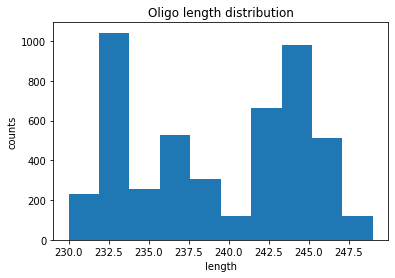

In [8]:
oligo_list = []
length_list = []
for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
    os.chdir(subpool_dir)
    order_file = glob.glob(subpool_dir+f'/{OWNER}_{PROJECT}_*_{CHIP_BATCH}')[0]
    fp = open(order_file,'r')
    for line in fp:
        oligo_list.append(line.rstrip())
        length_list.append(len(line.rstrip()))
    fp.close()
print(f'Total number of Oligo {len(oligo_list)}')
fp = open(PARENT_DIR + f'/{OWNER}_{PROJECT}_{CHIP_BATCH}','w')
fp.write('\n'.join(oligo_list))
fp.close()
print(f'Write into file {OWNER}_{PROJECT}_{CHIP_BATCH}.')

plt.hist(length_list)
plt.title('Oligo length distribution')
plt.xlabel('length')
plt.ylabel('counts')

### Unused blocks

In [ ]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-precompute_ig true
-detect_disulf false
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
"""
# pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
pyrosetta.init(" ".join(flags.replace("\n\t", " ").split()))

t = finalize_design(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/03_detail_0/0081/47f6c6fcb6d1e9c788e002cfeb798d0bfbc3f514e73931c8.pdb.bz2",
#         "-s": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/03_detail_0/0018/8aeb40fd33d90cbae3429aac01b14b7f45a054268e56fea7.pdb.bz2",
    }
)